# 14 폐렴아 기다려라!

## 14-1. 들어가며

딥러닝 기술이 도입된 도메인 중 하나가 의료분야.
영상분석 인력의 개인편차, 주관적판단, 오진의 부정확성을 극복할 만한 좋은 대안으로 여겨짐

일반적이 이미지처리와 다른 특징들.

1. 의료영상이미지는 개인정보보호로 인해서 데이터 구하기가 쉽지 않다.
2. 라벨링하는 인력이 비싸서 데이터셋 구축 비용이 비싸다.
3. 희귀질병은 데이터 입수 자체가 어렵다.
4. 음성/양성 데이터의 불균형이 심하다.
5. 이미지로만은 판단이 힘들어, 다른 데이터와 결합해서 해석해야 할 수도 있다.

### 목차
---------------------------------------------------------------------------
1. 의료영상에 대해
2. X-RAY 이미지
3. 폐렴을 진단해보자!
4. 직접 해보는 폐렴진단

## 14-2. 의료영상에 대해
### 1.1 사람 속을 보는 방법.
옛날에는 사람의 몸을 칼로 갈라서 확인해봤으나, 지금은 영상(X-RAY, CT)을 찍어서 확인을 한다.

### 1.2 의료 영상 종류  
  + X-RAY: 전자를 물체에 충돌시킬 떄 발생하는 투과력이 강한 전자기파. 밀도가 낮은 지방,근육은 통과하지만, 밀도가 높은 뼈, 금속은 통과X
  + CT: Computed Tomography의 줄임말로 환자를 중심으로 X-RAY를 빠르게 회전시켜 3D 이미지 영상을 만든 것. 쉽게 식별이 가능하고 위치파악 가능. 신체 단면 이미지를 slice라고 하는데, 단층 촬영이미지이라고도 하며 기존 X-RAY보다 더 자세한 정보 포함.
  + MRI: Magnetic Resonance Imaging의 줄임말로 강한 자기장을 사용해 CT, X-RAY보다 안전하다.
    

## 14-3. X-RAY 이미지

X-RAY 이미지를 기반으로 폐렴을 진단할 것이기에 X-RAY에 대해서 알아보자.  
  + Sagittal plane(시상면):사람 몸을 왼쪽, 오른쪽으로 나누는 면
  + Coronal plane(관상면):사람 몸을 앞 뒤로 나누는 면
  + Transverse plane(횡단면): 상반신, 하반신을 나누는 면
폐렴은 폐의 단면을 봐야 함으로 관상면 이미지를 보아야 한다.

### X-RAY 특성
---------------------------------------------------------------------------
전자기파가 몸을 통과한 결과를 이미지화시킨 것.  
통과하고 남은 전자기파를 기록한 것이기에 흑백으로 나온다.  
  + 뼈: 하얀색
  + 근육, 지방: 연한 회색
  + 폐, 공기: 검은색(폐에 대부분이 공기이므로 검은색이 나온다)

## 14-4. 폐렴을 진단해보자(1)
가장 핫한 분야는 질병을 탐지하는 인공지능.

이번에 쓸 데이터셋은 캐글의 Chest X-RAY Images입니다.
```
$ mkdir -p ~/aiffel/chest_xray
$ cd ~/Downloads && unzip archive.zip -d ~/aiffel
```
[캐글 흉부데이터](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

폐렴은 쉽게 말해서 폐에 염증이 생긴 것.  
염증이 쉽게 말해서 백혈구가 유해한 요소와 몸속에서 싸우는 것.  
폐렴이 걸린 사람의 폐를 X-RAY로 찍어보면 까만 부분에 음영이 생긴다.  
이런 패턴을 딥러닝 알고리즘에게 학습시켜 진단을 내리도록 해보자!

### 1. Set-up

In [1]:
#라이브러리 import
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/ssac19/aiffel


### 2. 데이터 가져오기
이미 train, val, test로 나눠져 있으니 그대로 불러오자.

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


갯수비가 89%, 10.7%, 0.3%이므로 val양이 너무 적기에 train에서 가져올 필요가 있다.
(train + val)*0.8=train, (train + val)*0.2=val로 분할

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


train 데이터에 존재하는 정상사람 폐사진과, 폐렴환자 폐사진 비율이 어떤지 확인해보자

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1077
Pneumonia images count in training set: 3108


train 데이터에 존재하는 정상사람 폐사진과, 폐렴환자 폐사진 비율이 1:3인데, 우리가 쓸 CNN모델은 클래스별 비율이 비슷할수록 성능이 좋기 때문에 나중에 전처리필요!
test, val은 그대로 둬도 된다!

tf.data 인스턴스를 만들어서 배치처리 작업을 좀더 효울적으로 하자.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


데이터 폴더 이름을 확인해보니 NORMAL, PNEUMONIA가 있는데,  
현재 데이터에 라벨링이 안되어 있으므로  
라벨데이터를 만드는 함수를 만들어보자

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

이미지 사이즈를 통일시키면 GPU의 메모리를 효율적으로 쓸 수 있으므로 이미지 사이즈를 같은 크기로 줄여보자.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path) # 라벨 값 갖고 오기
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수(AUTOTUNE)
# train, val 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
#사이즈와 라벨유무 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test 데이터 셋 만들기
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
#학습 데이터를 효율적으로 변환
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    #고정 크기 버퍼 유지, 해당 버퍼에서 무작위로 다음 요소 선택
    ds = ds.repeat()
    #epoch 진행시 여러번 데이터셋 불러온다.
    ds = ds.batch(BATCH_SIZE)
    #배치사이즈만큼 배치로 주어진다.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    #학습데이터를 나눠서 읽어와 데이터를 GPU에서 학습시키는 동안 다음 데이터를 CPU에서 준비해 리소스유휴상태를 줄인다.
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3. 데이터 시각화
 train의 첫 배치를 추출해 image와 label 데이터셋으로 나누고 결과사진을 보자.

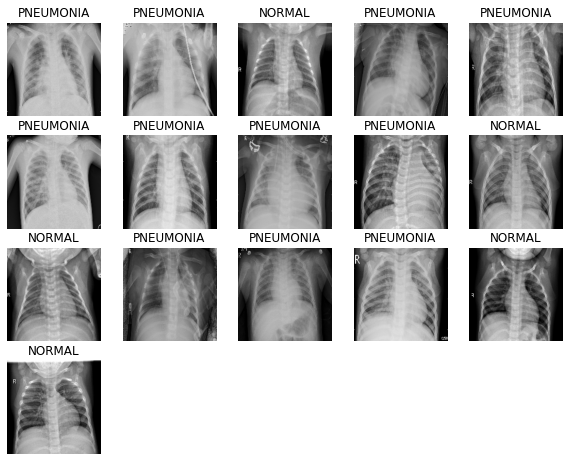

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## 14.5 폐렴을 진단해보자(2)

CNN 모델링
Convolution block(Convolution 2번, Batch Normalization, Max Pooling)
dense_block을 보면 Batch Normalization과 Dropout을 동시에(둘다 정규화) 사용하는데 일반적으로 금기시.  
예외적으로 성능을 향상시키는 경우도 있다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5.데이터 imbalance 처리
train데이터의 Normal과 Pneumonia의 언밸러스를 Weight balancing이란 테크닉으로 해결.
training set에서 각 데이터에 loss를 계산할때 특정 클래스 데이터에 더 큰 loss값 갖도록 가중치 부여.

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


### 6. 모델 훈련
이미지 훈련는 gpu를 선택.  
라벨이 2개여서 binary_cross entropy  
optimizer로 adam  
accuracy, precision, recall

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epoch1s=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 28s 107ms/step - loss: 0.4918 - accuracy: 0.7641 - precision: 0.9330 - recall: 0.7356 - val_loss: 0.5956 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 25s 95ms/step - loss: 0.2540 - accuracy: 0.8958 - precision: 0.9690 - recall: 0.8881 - val_loss: 0.9074 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 25s 96ms/step - loss: 0.2251 - accuracy: 0.9143 - precision: 0.9734 - recall: 0.9094 - val_loss: 0.1087 - val_accuracy: 0.9596 - val_precision: 0.9572 - val_recall: 0.9896
Epoch 4/25
261/261 [==============================] - 25s 96ms/step - loss: 0.1866 - accuracy: 0.9306 - precision: 0.9795 - recall: 0.9258 - val_loss: 0.1495 - val_accuracy: 0.9404 - val_precision: 0.9370 - val_recall: 0.9857
Epoch 5/25
261/261 [==============================] - 25s 96ms/step - loss: 0.1713 - accuracy: 

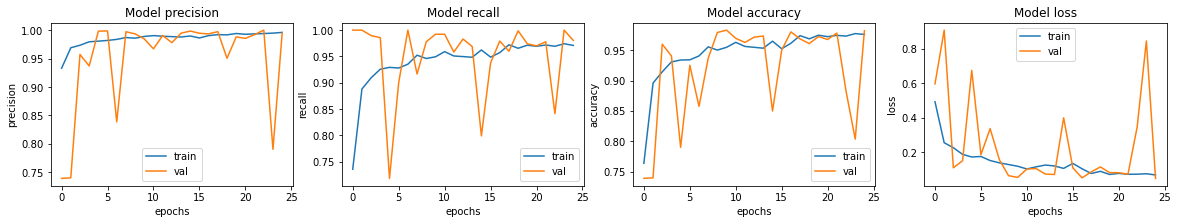

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 66ms/step - loss: 1.1152 - accuracy: 0.7901 - precision: 0.7515 - recall: 0.9923


의료데이터가 적어서  data augmentation을 사용.
의료분야에서는 주로 기본적인 data augmentation방법 사용
ex. 이미지 회전, 가우시안 노이즈 추가.
장기크기는 사람마다 거의 바뀌지 않아서 노이즈 추가등...

## 14-6. 프로젝트: 폐렴진단기 성능개선

### step 1. 실험환경 Set-up
Batch size, Epoch 변경가능

In [1]:
#라이브러리 import
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 8 #기본 배치 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/ssac19/aiffel


### Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성 진행.  
augmentation기법 고려해보자.  
하지만 신중하게 augmentation 도입!

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1086
Pneumonia images count in training set: 3099


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path) # 라벨 값 갖고 오기
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수(AUTOTUNE)
# train, val 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
#사이즈와 라벨유무 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test 데이터 셋 만들기
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#학습 데이터를 효율적으로 변환
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    #고정 크기 버퍼 유지, 해당 버퍼에서 무작위로 다음 요소 선택
    ds = ds.repeat()
    #epoch 진행시 여러번 데이터셋 불러온다.
    ds = ds.batch(BATCH_SIZE)
    #배치사이즈만큼 배치로 주어진다.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    #학습데이터를 나눠서 읽어와 데이터를 GPU에서 학습시키는 동안 다음 데이터를 CPU에서 준비해 리소스유휴상태를 줄인다.
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [14]:
#좌우반전예시
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step 3.데이터 시각화
augmentation 후에 적용되었는지 show_batch()로 확인해보자!

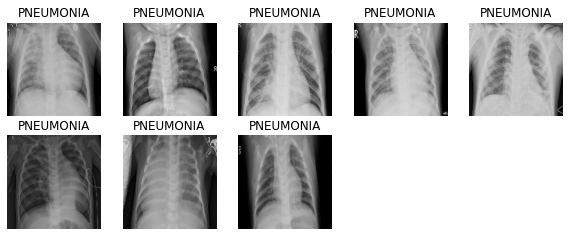

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(8):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. CNN 모델링
Convolution filter, 채널 개수, activation, 모델구조등을 바꿔보자.
Dropout, BatchNormalization을 변경해보자.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),
        dense_block(256, 0.5),
        dense_block(128, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step 5. 데이터 imbalance 처리
class_weight를 생략한다면?
recall을 강조하기 위해 페렴데이터를 잘 맞추는 것을 더 강화하는 효과?

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.68


### Step 6. 모델 훈련
loss함수 변경은 X
optimizer나 learning rate 변경 고려

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
523/523 [==============================] - 35s 67ms/step - loss: 0.3841 - accuracy: 0.8291 - precision: 0.9512 - recall: 0.8109 - val_loss: 1.0464 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 2/25
523/523 [==============================] - 30s 57ms/step - loss: 0.2973 - accuracy: 0.8767 - precision: 0.9634 - recall: 0.8663 - val_loss: 0.7152 - val_accuracy: 0.6740 - val_precision: 1.0000 - val_recall: 0.5648
Epoch 3/25
523/523 [==============================] - 30s 57ms/step - loss: 0.2597 - accuracy: 0.8889 - precision: 0.9687 - recall: 0.8783 - val_loss: 0.1698 - val_accuracy: 0.9365 - val_precision: 0.9917 - val_recall: 0.9229
Epoch 4/25
523/523 [==============================] - 59s 113ms/step - loss: 0.2692 - accuracy: 0.8870 - precision: 0.9646 - recall: 0.8796 - val_loss: 0.1898 - val_accuracy: 0.9567 - val_precision: 0.9791 - val_recall: 0.9628
Epoch 5/25
523/523 [==============================] - 33s 64ms/step - loss: 0.2261 - accuracy: 

### Step 7. 결과 확인과 시각화
accuracy도 중요하지만, recall도 중요하다!
hisotry 그래프 면밀히 살펴볼것!

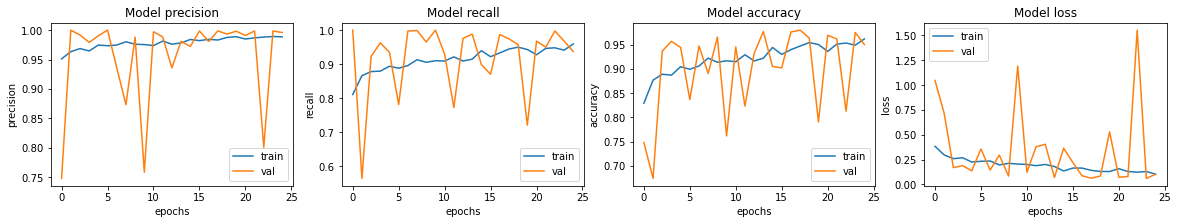

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, acc, prec, rec = model.evaluate(test_ds)

78/78 [==============================] - 3s 34ms/step - loss: 0.7485 - accuracy: 0.8558 - precision: 0.8289 - recall: 0.9692
